# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

-  
- 
- 
- 



# Part 0 - Importing the required packages

In [1]:
import pandas as pd # for use of dataframes
import numpy as np
import matplotlib.pyplot as plt # for plotting graphs 
import statsmodels.api as sm # for fitting an OLS model
import scipy.stats as stats # for access to tests for normal distribution
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, normaltest # for access to t tests, normal test
%matplotlib inline

# Part 1 - Introduction and Background

Chicago, otherwise known as 'The Windy City', has some of the worst crime rates in America. Some of this has to do with statitical flukes; it is the third largest city in the U.S., which makes any type of criminal activity more easily reportable. However, most people wouldn't argue over the real danger you are in when you go to some of the worse off areas of Chicago.

We wanted to analyze the crime rates in Chicago in some way in order to assist people in the city in understanding what problems exist and where they are happening. In the end, we decided to ask the following question:

"Does the district a crime is committed in or type of crime more closely predict whether an arrest was made".

The answers derived from the answer to this question could spawn further analysis, e.g.:

1. If a particular crime is more likely to result in an arrest in one district over the other, why is that? Is it the police in that district? Is it the citizens? Or is it the geography?

2. If the type of crime affects whether an arrest is made, does that mean that we are more afraid of certain crimes over others? Is this a valid fear? 

# Part 2 - Data Description

We are using this dataset: https://www.kaggle.com/chicago/chicago-crime

This is chicago crime data from 2001 to present. It represents all reported instances of crime, and whether or not an arrest has been made since the data was last released. Each row represents a crime, except for multiple homicides, for which there is a different row for each victim of the crime. 

Here are some basic stats:

In [2]:
crime = pd.read_csv('/Users/alvin/Downloads/Crimes_-_2001_to_present.csv')

In [3]:
crime.describe()

,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,6.808630e+05,680863.000000,680863.000000,676588.000000,676455.000000,6.776110e+05,6.776110e+05,680863.000000,677611.000000,677611.000000
mean,8.567042e+06,1175.978743,11.308450,22.770445,37.770586,1.164485e+06,1.885306e+06,2011.814654,41.840877,-87.671938
std,8.225777e+05,698.030896,6.916479,13.753105,21.547608,1.653952e+04,3.170872e+04,1.349423,0.087219,0.060123
min,2.755000e+03,111.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,2001.000000,36.619446,-91.686566
25%,8.217138e+06,621.000000,6.000000,10.000000,23.000000,1.152671e+06,1.858662e+06,2011.000000,41.767524,-87.714810
50%,8.750056e+06,1031.000000,10.000000,22.000000,32.000000,1.165933e+06,1.890256e+06,2012.000000,41.854636,-87.666379
75%,9.032286e+06,1723.000000,17.000000,34.000000,58.000000,1.176352e+06,1.909012e+06,2013.000000,41.906133,-87.628220
max,1.050916e+07,2535.000000,31.000000,50.000000,77.000000,1.205119e+06,1.951573e+06,2016.000000,42.022710,-87.524529


In [4]:
print('Total Number of Crimes:\t\t\t{0}'.format(len(crime)))
print('Total number of Unique Districts:\t{0}'.format(len(crime['District'].unique())))

Total Number of Crimes:			680863
Total number of Unique Districts:	23


# Part 3 - Data Cleaning and Preprocessing

This data is fairly clean, because it is maintained by the Chicago Police Department, which has high organizational standards. There aren't very many invalid crimes or unknowns.

To clean the data, we will do the following (not necessarily in order):

1. Drop useless columns
2. Standardize the location description
3. Standardize the crime type to get rid of the uppercase, standardize the non-criminal type
4. Remove NaN values

In [5]:
# first, drop the location description column and community area column because 
crime = crime.drop(['Location Description', 'Block', 'Community Area','Latitude', 'Beat', 'Ward','Longitude','X Coordinate','Y Coordinate','Location','Ward'],axis=1)

In [6]:
"""
    Author: James McDougall
    Param: string - is the string which is the name of the Primary Type
    Returns: a variable of type str which is lower case and represents  a more standardized type
"""
def standardize_primary_type(string):
    # compile all non-criminal offenses into on label
    if string == 'NON-CRIMINAL (SUBJECT SPECIFIED)' or string == 'NON - CRIMINAL' or string == 'NON-CRIMINAL':
        return 'non-criminal'
    if string == 'OTHER OFFENSE':
        return 'other'
    # rename crim sexual assault to just sexual assault to make it easier to read
    if string == 'CRIM SEXUAL ASSAULT':
        return 'sexual assault'
    else:
        # everything else, make sure to lowercase it so we don't have to use caps lock lol
        return string.lower()
        

In [7]:
to_drop = crime[ crime['District'].isnull()]
print('Number of rows to drop with NaN district: ' + str(len(to_drop)))
crime = crime.drop(to_drop.index,axis=0)

to_drop = crime[crime['Primary Type'].isnull()]
print('Number of row to drop with NaN Primary Type: ' + str(len(to_drop)))
crime = crime.drop(to_drop.index,axis=0)

Number of rows to drop with NaN district: 0
Number of row to drop with NaN Primary Type: 0


In [8]:
crime['Type'] = crime['Primary Type'].apply(standardize_primary_type)
crime['District'] = crime['District'].astype(str)

def arrest_to_int(string):
    if string == True:
        return 1
    elif string == False:
        return 0
crime['Arrest'] = crime['Arrest'].apply(arrest_to_int)


# Part 4 - Data Visualization

First, we want to look at the top three crime types

In [9]:
crime['Primary Type'].value_counts().nlargest(3)

THEFT        152489
BATTERY      118893
NARCOTICS     74629
Name: Primary Type, dtype: int64

<BarContainer object of 29 artists>

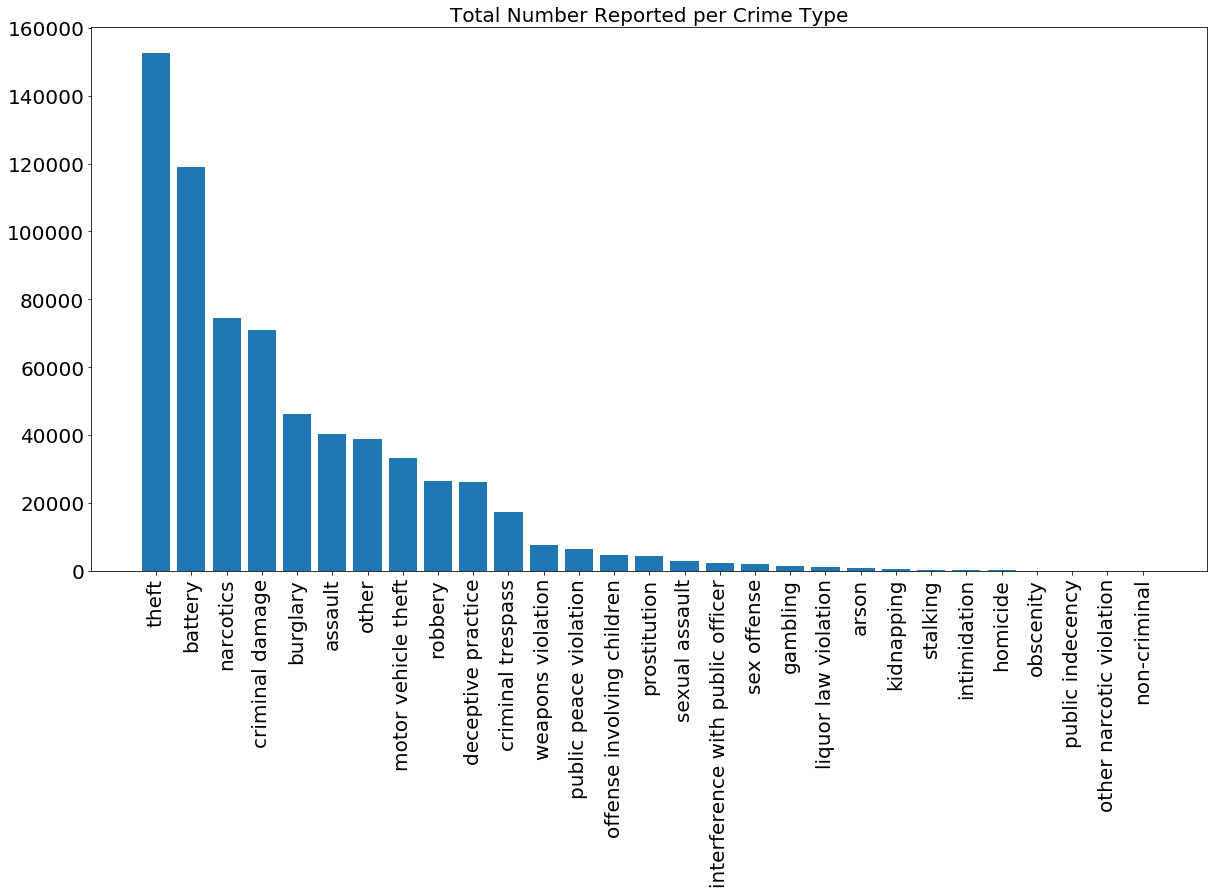

In [10]:
plt.figure(figsize=(20,10))
crimeType = plt.bar(crime.Type.value_counts().index, crime.Type.value_counts())
plt.title('Total Number Reported per Crime Type', fontsize='20')
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=20)
crimeType

Let's first get the total count of crimes that were reported at each district and visualize them in a bar graph for easy comparison.

In [11]:
districts = crime['District'].unique()
district_cache = {}
arrest_cache = {}
ratio_cache = {}
for district in districts:
    district_cache[district] = len(crime[ crime['District'] == district ]) #gets total num of crimes in each district
    arrest_cache[district] = len(crime[ (crime['Arrest'] == True) & (crime['District'] == district)]) #gets total num of arrests per district
    ratio_cache[district] = arrest_cache[district] / district_cache[district] #gets the ratio of arrests per crime in each district 
print(district_cache)
print(arrest_cache)
print(ratio_cache)

{'10': 30448, '9': 34569, '18': 28690, '5': 30903, '16': 22599, '19': 31026, '2': 28421, '17': 19713, '1': 24813, '15': 30056, '8': 46880, '22': 22328, '6': 39996, '14': 25030, '12': 32439, '7': 41014, '3': 35816, '11': 44801, '25': 40388, '4': 40354, '20': 11035, '24': 19526, '31': 18}
{'10': 9997, '9': 10091, '18': 7085, '5': 8751, '16': 4167, '19': 6565, '2': 7217, '17': 4131, '1': 6948, '15': 12363, '8': 12210, '22': 5022, '6': 11883, '14': 4825, '12': 7310, '7': 12493, '3': 9471, '11': 19279, '25': 11573, '4': 9463, '20': 2670, '24': 4951, '31': 1}
{'10': 0.32833026799789805, '9': 0.29190893575168503, '18': 0.24695015684907634, '5': 0.28317639064168526, '16': 0.18438868976503386, '19': 0.21159672532714496, '2': 0.25393195172583655, '17': 0.20955714503119768, '1': 0.2800145085237577, '15': 0.41133217993079585, '8': 0.26045221843003413, '22': 0.22491938373342887, '6': 0.2971047104710471, '14': 0.19276867758689573, '12': 0.22534603409476248, '7': 0.30460330618813086, '3': 0.264434889

In [12]:
districtsTotalCrime = pd.DataFrame.from_dict(district_cache, orient='index')
districtsTotalCrime.columns = ['Total Crimes Reported']
districtsTotalCrime.index.name = 'District Number'
districtsTotalCrime.head()

,Total Crimes Reported
District Number,
10,30448
9,34569
18,28690
5,30903
16,22599


From this bar chart, we can see that the two districts with the msot crimes reported were Districts 8 and 11 while the two districts that had the least crimes reported were Districts 20 and 24. 

However, let's dive deeper into our data (specifically in the top three crime types). 

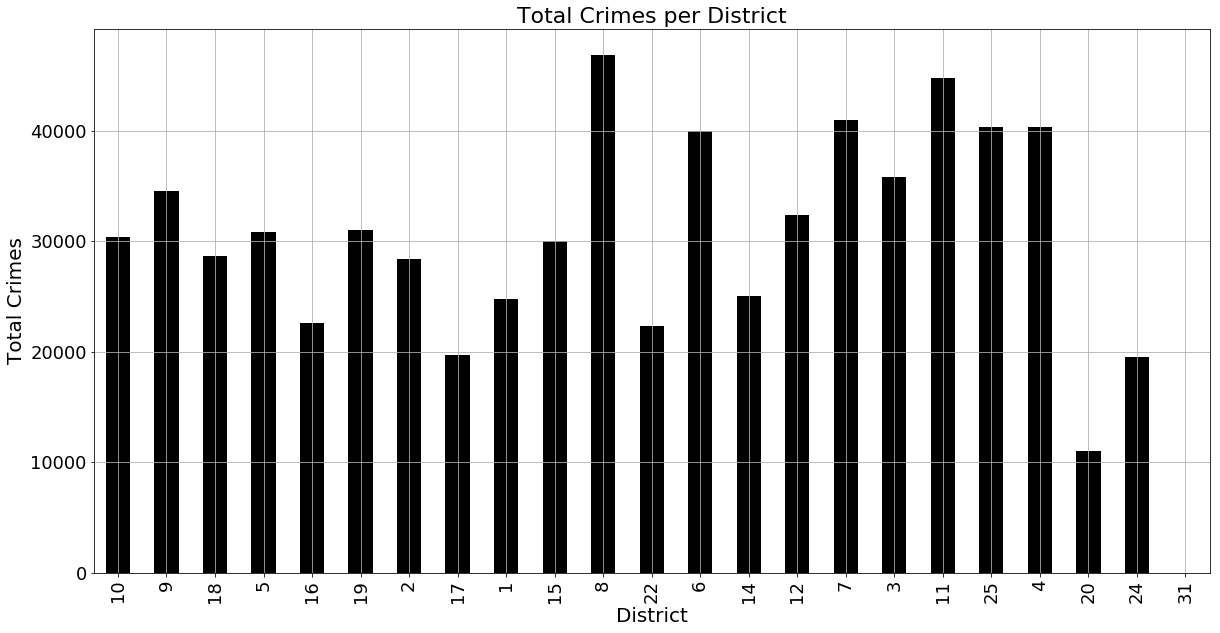

In [13]:
DTCchart = districtsTotalCrime.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='k')
DTCchart.set_title('Total Crimes per District', fontsize=22)
DTCchart.set_xlabel('District', fontsize=20)
DTCchart.set_ylabel('Total Crimes', fontsize=20)
DTCchart.tick_params(labelsize=18)
DTCchart

In [14]:
districtsRatio = pd.DataFrame.from_dict(ratio_cache, orient='index')
districtsRatio.columns = ['Arrest to Crime Ratio']
districtsRatio.index.name = 'District Number'
districtsRatio.head()

,Arrest to Crime Ratio
District Number,
10,0.328330
9,0.291909
18,0.246950
5,0.283176
16,0.184389


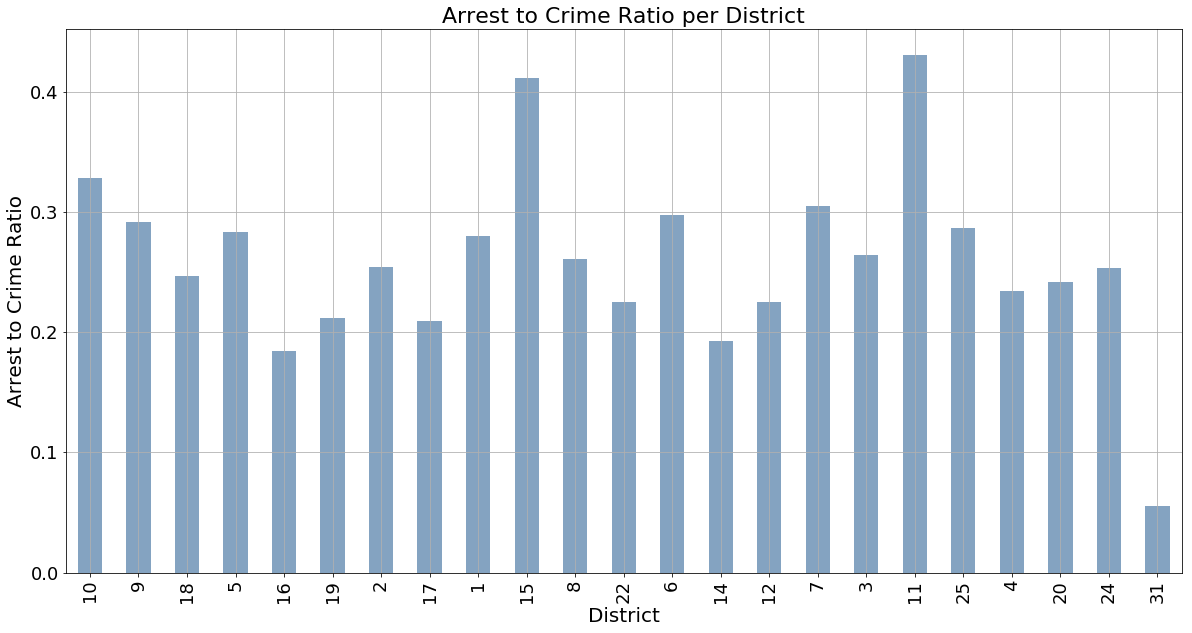

In [15]:
ratioChart = districtsRatio.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color=(0.2, 0.4, 0.6, 0.6))
ratioChart.set_title('Arrest to Crime Ratio per District', fontsize=22)
ratioChart.set_xlabel('District', fontsize=20)
ratioChart.set_ylabel('Arrest to Crime Ratio', fontsize=20)
ratioChart.tick_params(labelsize=18)
ratioChart

In [16]:
dist_pred_arrest = pd.DataFrame()
for district in districts:
    arrest_occurred = crime[crime['Arrest'] == True]   
    
    dist_pred_arrest.loc[district, 'Reported Theft'] = len(crime[(crime['Primary Type'] == 'THEFT') & (crime['District'] == district)]) 
    dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] = len(arrest_occurred[(arrest_occurred['Primary Type'] == 'THEFT') & (arrest_occurred['District'] == district)])
    dist_pred_arrest.loc[district,'Theft Arrest Rate'] = dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Theft']
    
    dist_pred_arrest.loc[district, 'Reported Battery'] = len(crime[(crime['Primary Type'] == 'BATTERY') & (crime['District'] == district)]) 
    dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] = len(arrest_occurred[(arrest_occurred['Primary Type'] == 'BATTERY') & (arrest_occurred['District'] == district)])
    dist_pred_arrest.loc[district,'Battery Arrest Rate'] = dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Battery']
    
    dist_pred_arrest.loc[district, 'Reported Criminal Damage'] = len(crime[(crime['Primary Type'] == 'CRIMINAL DAMAGE') & (crime['District'] == district)]) 
    dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] = len(arrest_occurred[(arrest_occurred['Primary Type'] == 'CRIMINAL DAMAGE') & (arrest_occurred['District'] == district)])
    dist_pred_arrest.loc[district,'Criminal Damage Arrest Rate'] = dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Criminal Damage']
    
print(dist_pred_arrest) 

    Reported Theft  Theft w/ Arrest Made  Theft Arrest Rate  Reported Battery  \
10          4782.0                 406.0           0.084902            6443.0   
9           6340.0                 676.0           0.106625            6295.0   
18         13534.0                1893.0           0.139870            3094.0   
5           4630.0                 272.0           0.058747            6550.0   
16          5507.0                 370.0           0.067187            3105.0   
19         11211.0                 982.0           0.087593            3753.0   
2           6326.0                 535.0           0.084572            5377.0   
17          4737.0                 629.0           0.132784            3143.0   
1          11846.0                2055.0           0.173476            2296.0   
15          3821.0                 233.0           0.060979            6100.0   
8           9745.0                1369.0           0.140482            7392.0   
22          4792.0          

Previously, we found out the top three crime types (in terms of total reports). From the dataframe above, we are able to gain access to the number of each of these three crime reported, number of arrests that stemmed from each crime, and the arrest ratio, for each district. Now, we can plot this data to see it all visually.  

First, let's see the ratios of our top 3 crimes arrest per district.

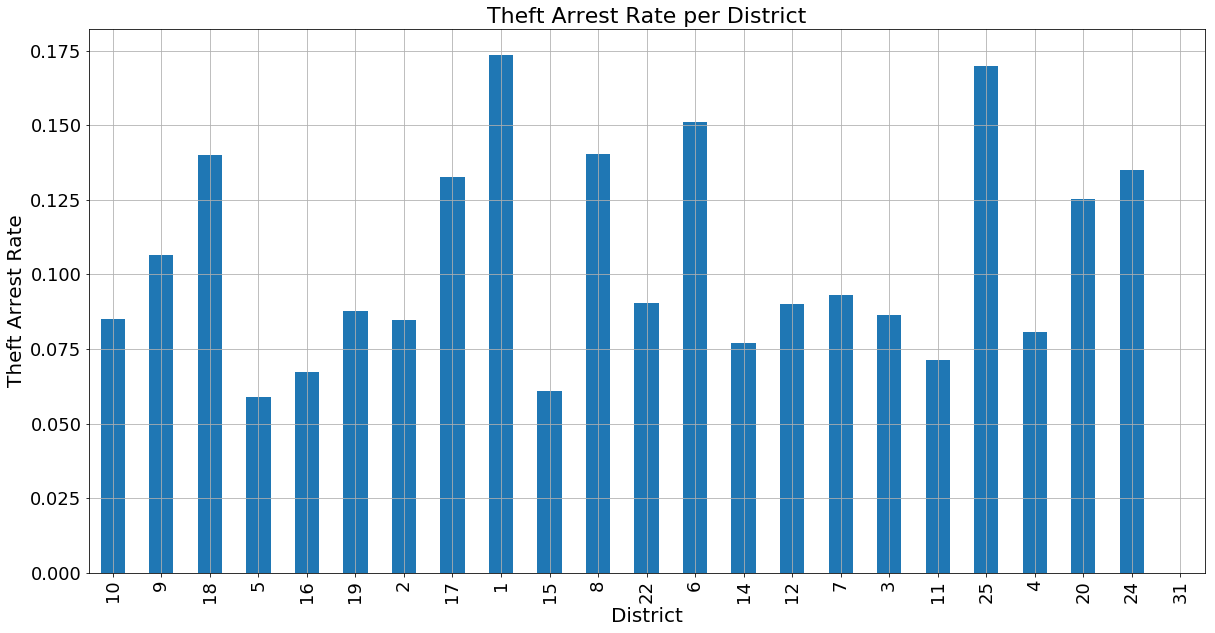

In [17]:
thefts = dist_pred_arrest['Theft Arrest Rate'] 
theftRate = thefts.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='tab:blue') 
theftRate.set_title('Theft Arrest Rate per District', fontsize=22)
theftRate.set_xlabel('District', fontsize=20)
theftRate.set_ylabel('Theft Arrest Rate', fontsize=20)
theftRate.tick_params(labelsize=18)
theftRate

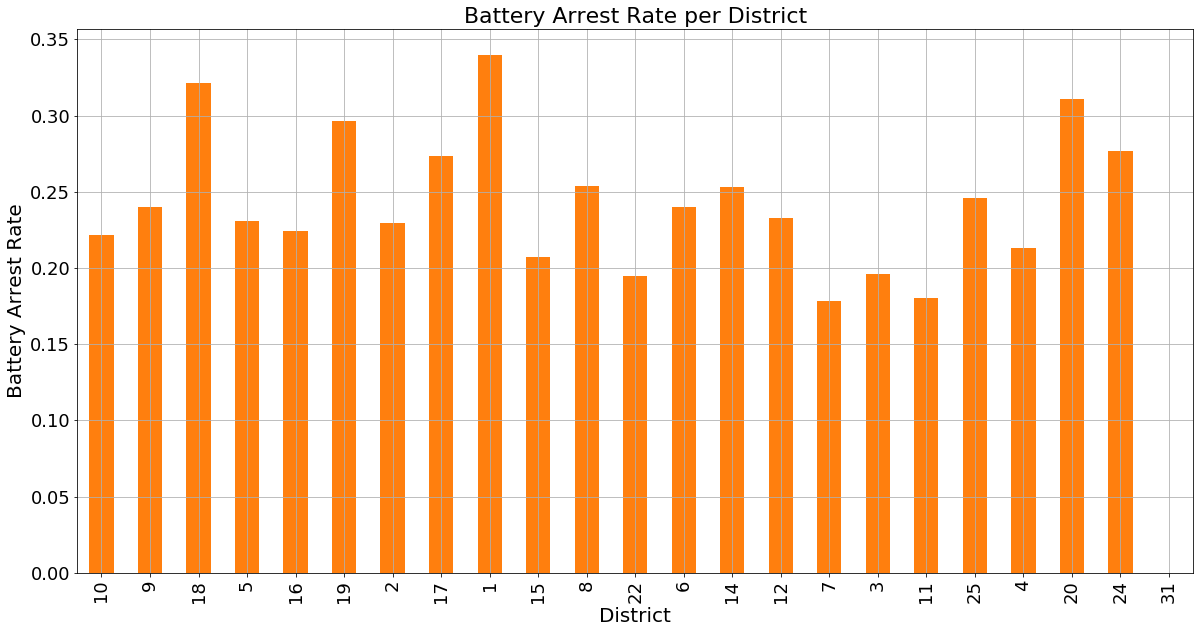

In [18]:
battery = dist_pred_arrest['Battery Arrest Rate'] 
batteryRate = battery.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='tab:orange') 
batteryRate.set_title('Battery Arrest Rate per District', fontsize=22)
batteryRate.set_xlabel('District', fontsize=20)
batteryRate.set_ylabel('Battery Arrest Rate', fontsize=20)
batteryRate.tick_params(labelsize=18)
batteryRate

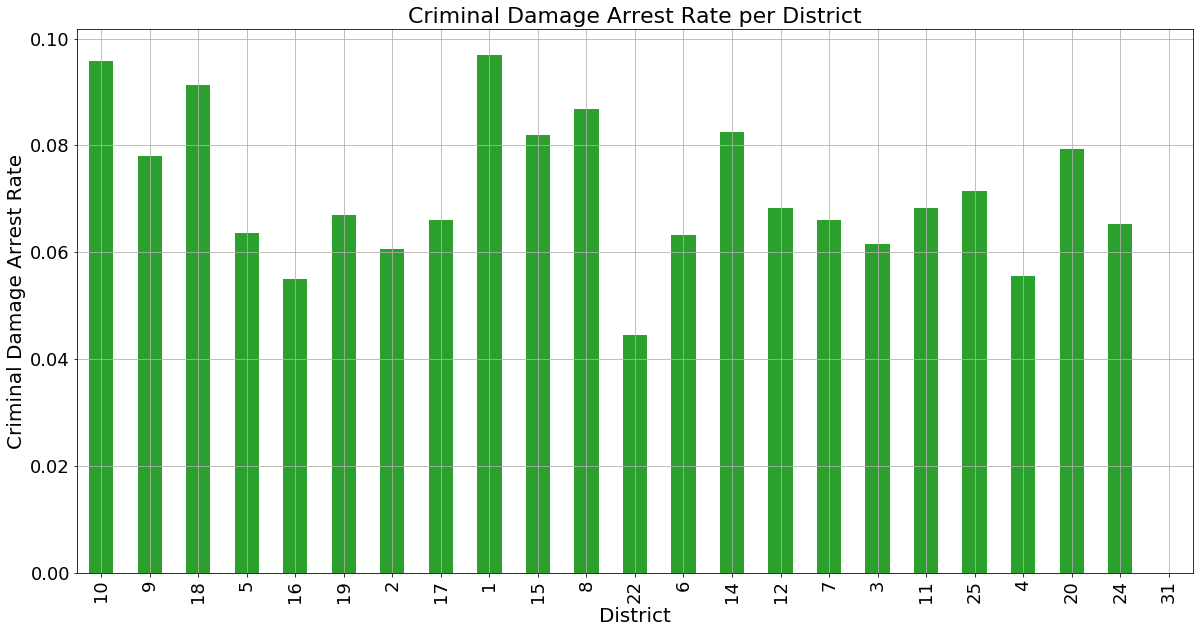

In [19]:
criminal = dist_pred_arrest['Criminal Damage Arrest Rate'] 
criminalRate = criminal.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='tab:green') 
criminalRate.set_title('Criminal Damage Arrest Rate per District', fontsize=22)
criminalRate.set_xlabel('District', fontsize=20)
criminalRate.set_ylabel('Criminal Damage Arrest Rate', fontsize=20)
criminalRate.tick_params(labelsize=18)
criminalRate

# Part 5 - Data Analysis and Results

In [20]:
binomial_model = smf.glm(formula='Arrest ~ Type + District', data=crime,family=sm.families.Binomial())
binomial_results = binomial_model.fit()
binomial_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Arrest   No. Observations:               680863
Model:                            GLM   Df Residuals:                   680812
Model Family:                Binomial   Df Model:                           50
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3898e+05
Date:                Sun, 17 Mar 2019   Deviance:                   4.7796e+05
Time:                        17:43:25   Pearson chi2:                 6.84e+05
No. Iterations:                    22   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -1.5564      0.106    -14.690      0.000      -1.764      -1.349
Type[T.assault]                              0.9821      0.105      9.334      0.000       0.776       1.188
Type[T.battery]                              0.8854      0.105      8.448      0.000       0.680       1.091
Type[T.burglary]                            -0.7827      0.107     -7.342      0.000      -0.992      -0.574
Type[T.criminal damage]                     -0.4993      0.106     -4.728      0.000      -0.706      -0.292
Type[T.criminal trespass]                    3.1264      0.106     29.483      0.000       2.919       3.334
Type[T.deceptive practice]                   0.6621      0.106      6.262      0.000       0.455       0.869
Type[T.gambling]                             8.3399      0.587     14.200      0.000       7.189       9.491
Type[T.homicide]                             2.5819      0.167     15.477      0.000       2.255       2.909
Type[T.interference with public officer]     4.8266      0.134     35.932      0.000       4.563       5.090
Type[T.intimidation]                         0.7074      0.173      4.080      0.000       0.368       1.047
Type[T.kidnapping]                           0.1403      0.168      0.834      0.404      -0.189       0.470
Type[T.liquor law violation]                 6.4843      0.289     22.474      0.000       5.919       7.050
Type[T.motor vehicle theft]                 -0.7877      0.107     -7.337      0.000      -0.998      -0.577
Type[T.narcotics]                            7.4316      0.117     63.437      0.000       7.202       7.661
Type[T.non-criminal]                         1.7661      0.775      2.279      0.023       0.247       3.285
Type[T.obscenity]                            3.4759      0.327     10.621      0.000       2.835       4.117
Type[T.offense involving children]           0.6415      0.111      5.772      0.000       0.424       0.859
Type[T.other]                                0.4889      0.105      4.636      0.000       0.282       0.696
Type[T.other narcotic violation]             2.0229      0.684      2.959      0.003       0.683       3.363
Type[T.prostitution]                         7.4921      0.253     29.660      0.000       6.997       7.987
Type[T.public indecency]                    25.4535   1.52e+04      0.002      0.999   -2.98e+04    2.99e+04
Type[T.public peace violation]               3.1878      0.108     29.387      0.000       2.975       3.400
Type[T.robbery]                             -0.1130      0.107     -1.060      0.289      -0.322       0.096
Type[T.sex offense]                          1.2711      0.115     11.096      0.000       1.047       1.496
Type[T.sexual assault]                       0.3934      0.117      3.367      0.001       0.164       0.622
T

# Part 6 - Privacy/Ethics Considerations

##### Privacy
For the purpose of our analysis, we do have permission to use this dataset becauset the police department released as public record. The data is also fairly private because there is no individual person identifying information. There are no names, only crime ids and description. The only identifying information is the location (partial addresses and longitude/latitude). This could be an issue because some of the crimes occurred in apartments, so you could conceivably find out the location where a crime was committed and use this to find someone. However, for our project purposes, we decided to use district # instead so we simply dropped those other location identifying sections from our data to further perserve the privacy of those involved when we release our findings.

##### Ethics
A potential ethics considerations involving this data is that we are publicizing the locations of high crime, which could be used to discriminate against communities. While this data is publicily available, we are organizing and formatting it in a way that can be used to show which districts have a high crime rate. People with ill intentions could use this to argue that no one should go near these areas, alientating those communities. 

# Part 7 - Conclusions and Discussion

##### Potential Biases
